# Running k=2

## Loading the data and importing packages

In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, pairwise_distances_argmin_min, silhouette_samples

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx
from matplotlib.lines import Line2D
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import folium

In [2]:
X_ = np.load("scaled-df.npy")
df = pd.read_csv("bofedales-clean.csv")
df.drop("Unnamed: 0", axis=1, inplace=True)
df.head(1)

,Area_m2,AUC,pct_prot,elev_mean_,elev_std_m,n_wells,Ground Water Rights 1966-01-01,Ground Water Rights 1967-01-01,Ground Water Rights 1968-01-01,Ground Water Rights 1969-01-01,...,NDWI 2019-03,NDWI 2019-04,NDWI 2019-05,NDWI 2019-06,NDWI 2019-07,NDWI 2019-08,NDWI 2019-09,NDWI 2019-10,NDWI 2019-11,NDWI 2019-12
0,6300,86.769539,0.0,4162.714286,3.953815,0.0,0.0,0.0,0.0,0.0,...,0.03193,0.026136,0.022087,0.019181,0.023405,0.015355,-0.000504,0.004056,0.014678,0.010436


## Running k=2

In [3]:
K=2
kmeans = KMeans(n_clusters=K, random_state=42, n_init=20)
cluster_labels = kmeans.fit_predict(X_)
centroids_pca = kmeans.cluster_centers_ 

In [4]:
df["cluster"] = cluster_labels

### Measuring fit

In [5]:
inertia = kmeans.inertia_

avg_sq_dist_per_sample = inertia / X_.shape[0]

print(f"Average squared distance per point: {avg_sq_dist_per_sample:.4f}")

mu = X_.mean(axis=0)
global_mse = ((X_ - mu)**2).sum(axis=1).mean()
print(f"Global mean: {global_mse}")

Average squared distance per point: 907.8377
Global mean: 2159.8318653940732


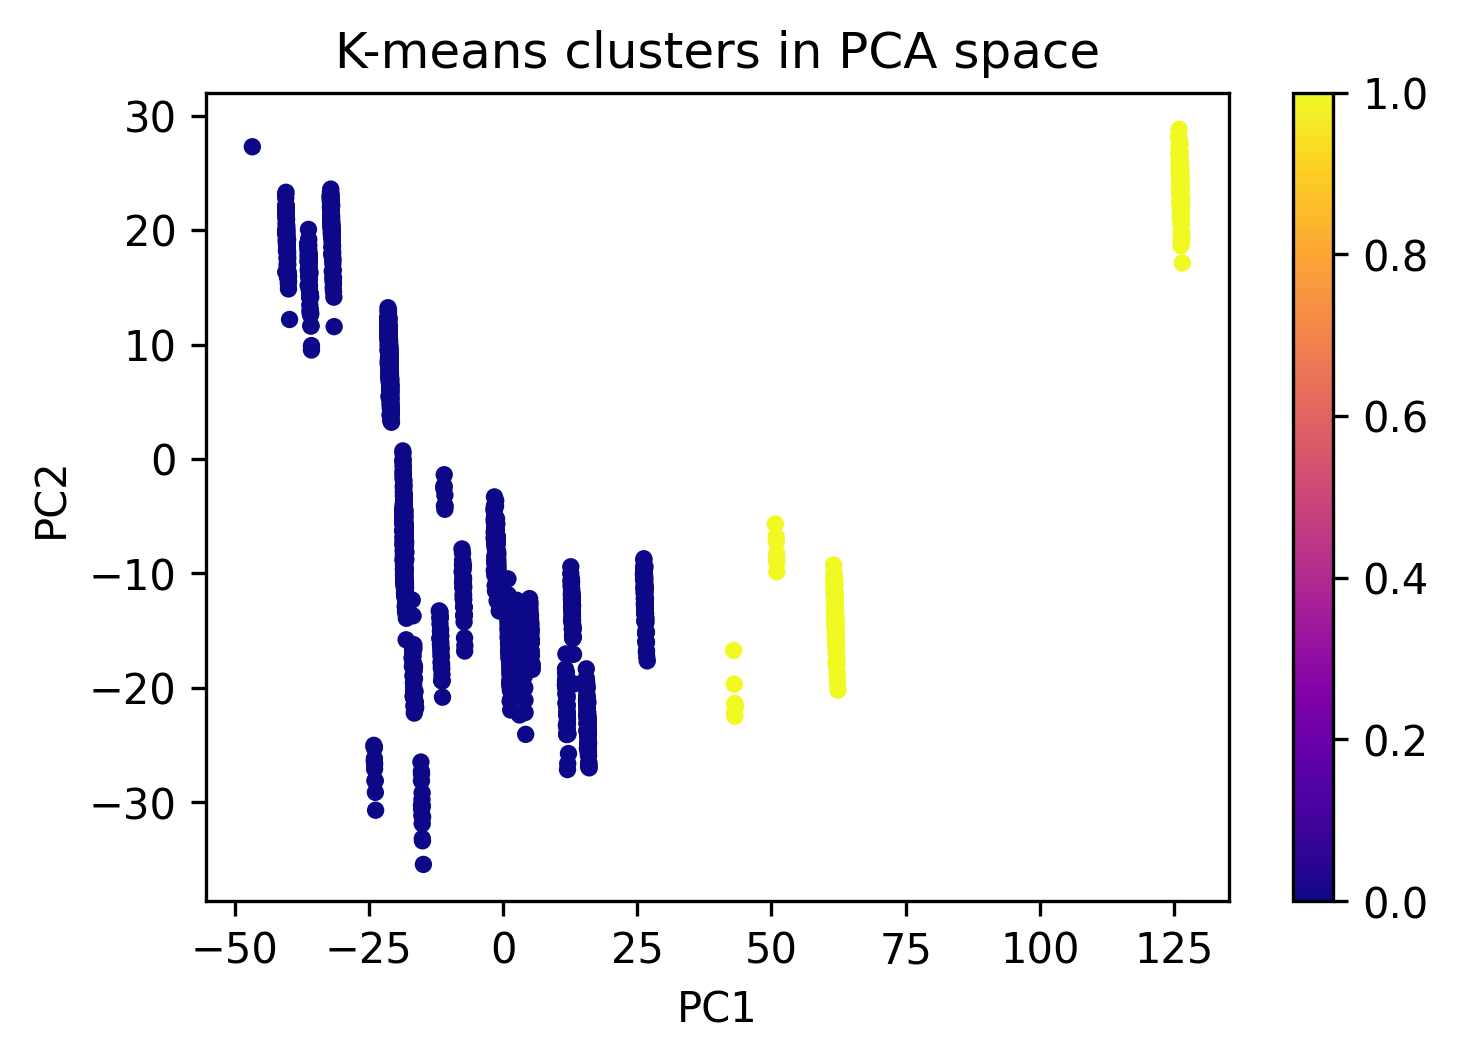

In [6]:
pca2 = PCA(n_components=2).fit_transform(X_)
plt.scatter(pca2[:,0], pca2[:,1], c=cluster_labels, s=10, cmap='plasma')
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.title('K-means clusters in PCA space')
plt.colorbar()
plt.show()

## Data Visualizations

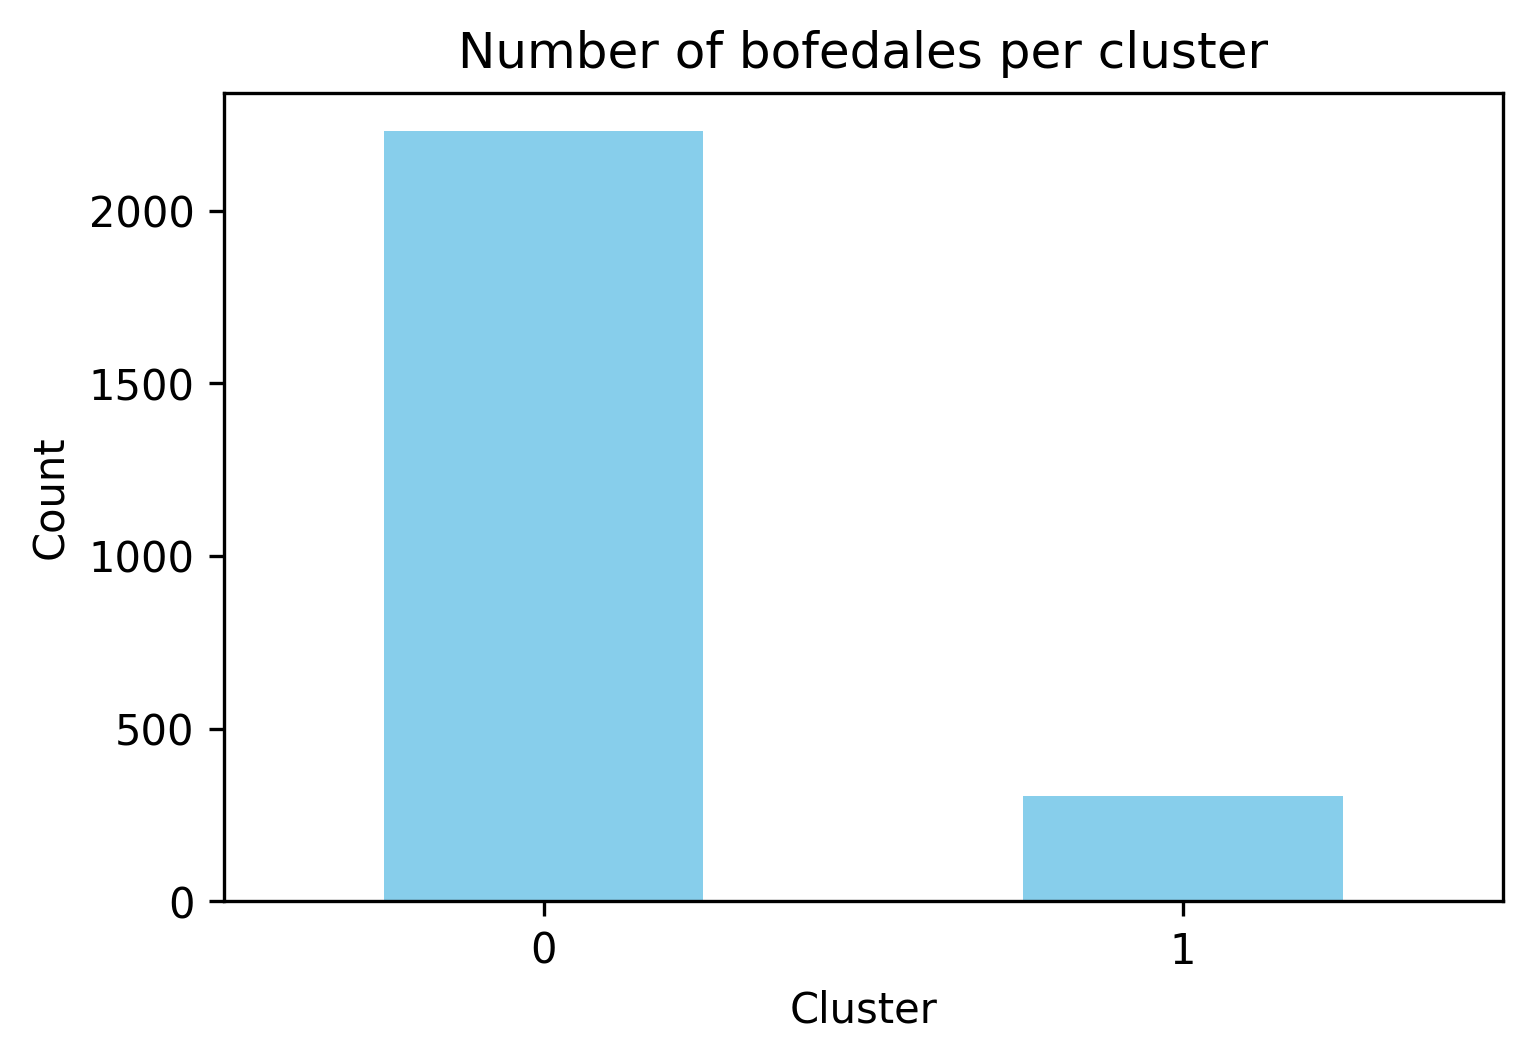

In [7]:
pd.Series(df["cluster"]).value_counts().sort_index().plot.bar(color='skyblue')
plt.xlabel("Cluster"); plt.ylabel("Count")
plt.title("Number of bofedales per cluster")
plt.xticks(rotation=0)
plt.show()

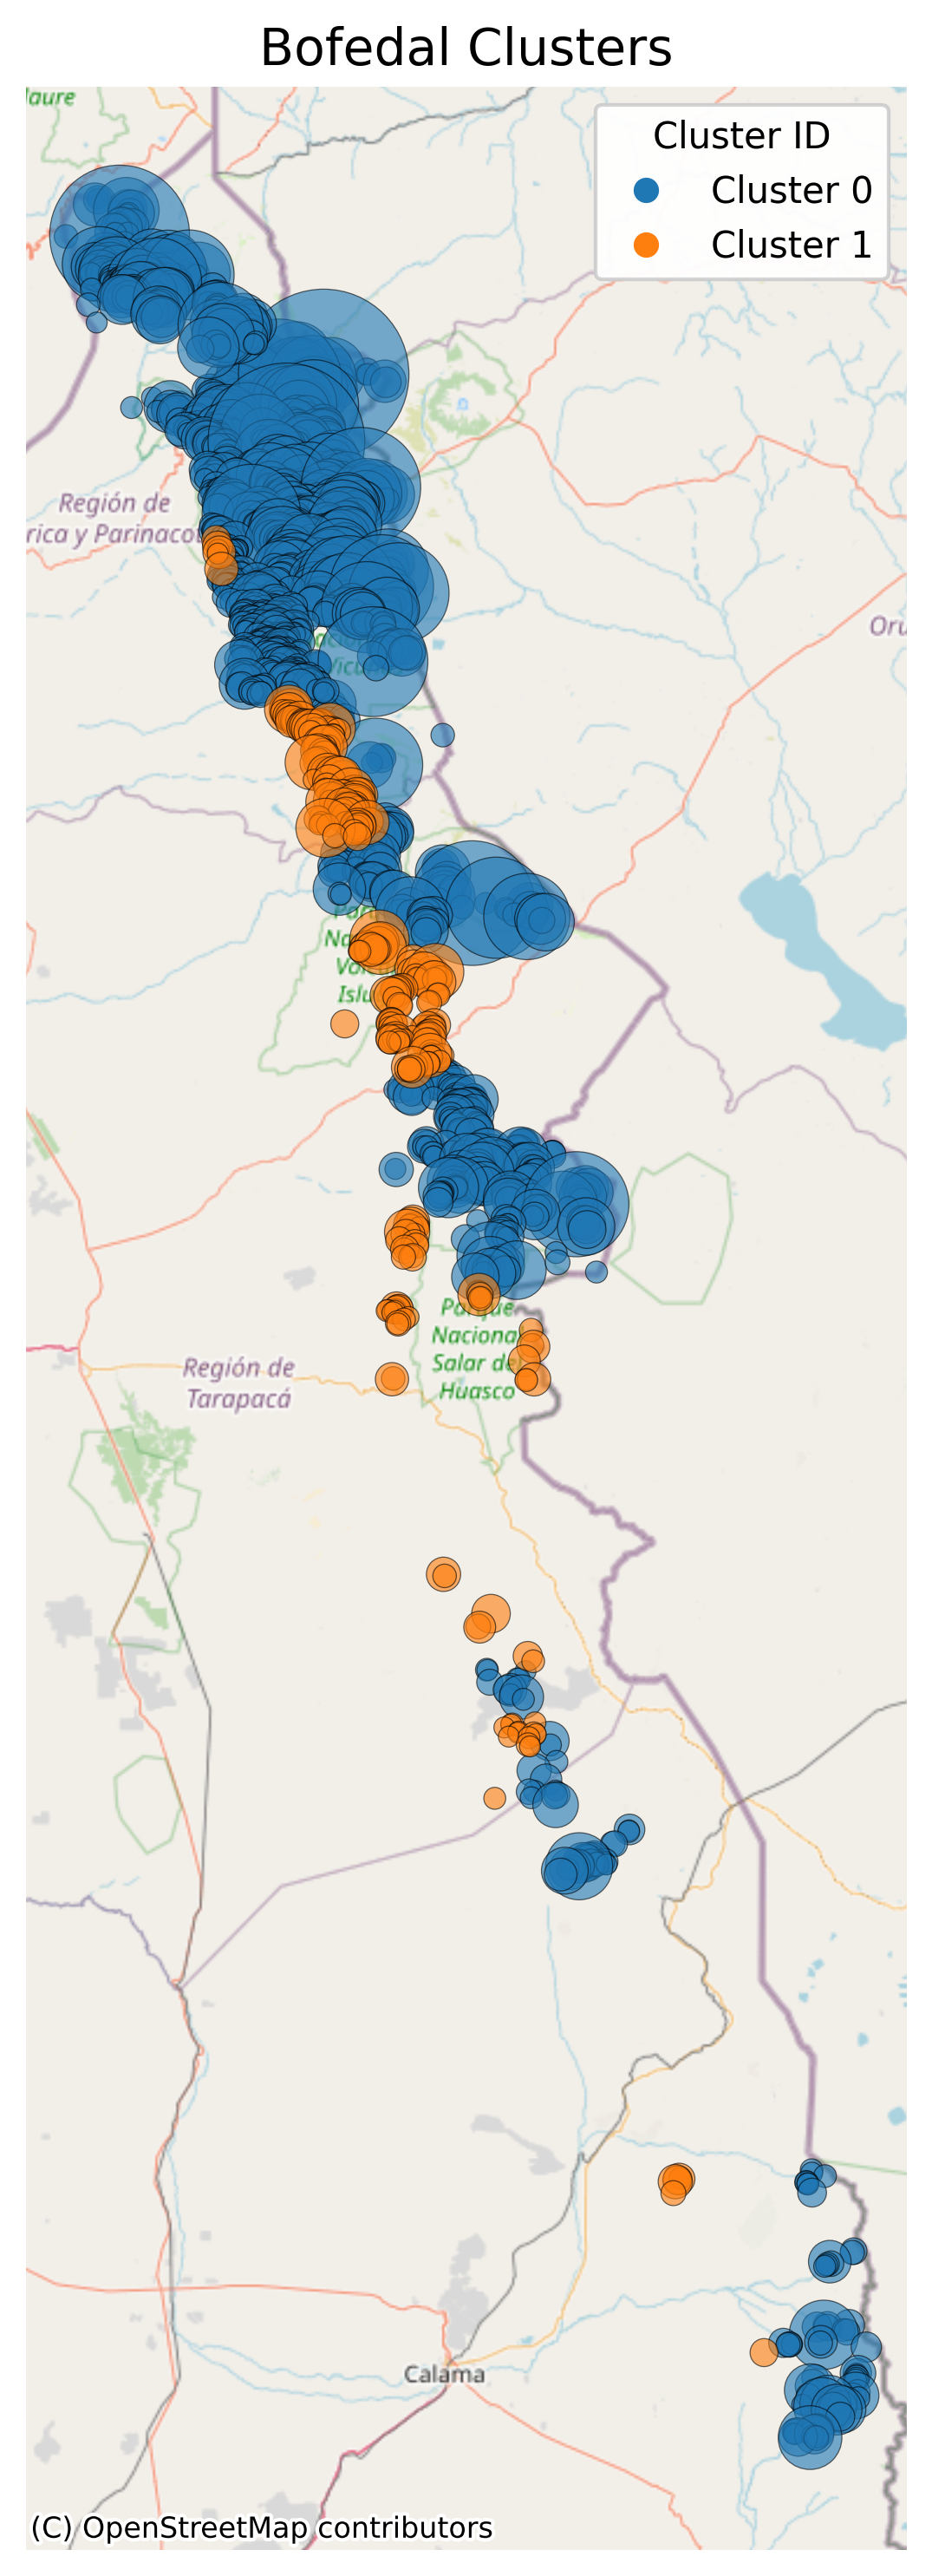

In [8]:
geometry = [Point(xy) for xy in zip(df.lon, df.lat)]

gdf = gpd.GeoDataFrame(
    df.copy(), 
    geometry=geometry,
    crs="EPSG:4326"
)

gdf["size_for_plot"] = gdf["Area_m2"].apply(lambda a: (a**0.5))

scale_factor = 0.5
gdf["size_for_plot"] *= scale_factor

gdf_3857 = gdf.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(8, 10))

cmap = plt.get_cmap("tab10")

for i, cluster_id in enumerate(sorted(gdf_3857["cluster"].unique())):
    subset = gdf_3857[gdf_3857["cluster"] == cluster_id]
    
    ax.scatter(
        subset.geometry.x, 
        subset.geometry.y,
        s=subset["size_for_plot"],
        c=[cmap(i)],
        alpha=0.6,
        edgecolor="k",
        linewidth=0.3,
        label=f"Cluster {cluster_id}"
    )

ctx.add_basemap(
    ax,
    source=ctx.providers.OpenStreetMap.Mapnik,
)

cluster_handles = []
for idx, cluster_id in enumerate(sorted(gdf_3857["cluster"].unique())):
    cluster_handles.append(
        Line2D(
            [], [], 
            marker="o", 
            markersize=6,
            color=cmap(idx),
            linestyle="",
            label=f"Cluster {cluster_id}",
        )
    )

legend1 = ax.legend(handles=cluster_handles, title="Cluster ID", loc="upper right")
ax.add_artist(legend1)

ax.set_aspect('equal', adjustable='box')

ax.set_axis_off()
ax.set_title("Bofedal Clusters", fontsize=14)
plt.tight_layout()
plt.show()

## Feature Importance

In [9]:
X_num = (
    df 
    .select_dtypes('number')
    .drop(columns=['cluster'], errors='ignore')
)

scaler = StandardScaler()
X_scaled = pd.DataFrame(
    scaler.fit_transform(X_num),
    columns=X_num.columns, 
    index=X_num.index
)

pca = PCA(n_components=6, svd_solver='full').fit(X_scaled)

pc1_loadings = pd.Series(
    pca.components_[0],
    index=X_scaled.columns,
    name='PC1 loading'
)

print(pc1_loadings.sort_values(key=np.abs, ascending=False).head(20))

Temp Max 2004-09-01    0.024813
Temp Max 1981-09-01    0.024785
Temp Max 1997-09-01    0.024768
Temp Max 1997-08-01    0.024747
Temp Max 1982-09-01    0.024742
Temp Max 2013-01-01    0.024735
Temp Max 1993-01-01    0.024733
Temp Max 2015-01-01    0.024730
Temp Max 1979-01-01    0.024713
Temp Max 2004-08-01    0.024706
Temp Max 1987-01-01    0.024690
Temp Max 2001-01-01    0.024690
Temp Max 2005-02-01    0.024681
Temp Max 2011-05-01    0.024677
Temp Max 2008-01-01    0.024676
Temp Max 1994-09-01    0.024675
Temp Max 1992-01-01    0.024672
Temp Max 2001-08-01    0.024669
Temp Max 1997-04-01    0.024662
Temp Max 2003-09-01    0.024662
Name: PC1 loading, dtype: float64


In [10]:
features = df.columns
families = {
    "NDVI":  [c for c in features if c.startswith("NDVI")],
    "NDWI":  [c for c in features if c.startswith("NDWI")],
    "GW_rights": [c for c in features if c.startswith("Ground Water Rights")],
    "SW_rights": [c for c in features if c.startswith("Surface Water Rights")],
    "Temperature": [c for c in features if c.startswith(("Temp Min", "Temp Max"))],
    "PET": [c for c in features if c.startswith("PET")],
    "Precipitation": [c for c in features if c.startswith("Precipitation")],
    "Size":   ["Area_m2", "AUC"],
    "Elevation": [c for c in features if c.startswith(("elev_std_m", "elev_mean_"))],
    "Boreholes": [c for c in features if c.startswith("n_wells")],
    "Protected Land": [c for c in features if c.startswith("pct_prot")]
}

summary = {k: pc1_loadings[fam].abs().sum() for k, fam in families.items()}
pd.Series(summary).sort_values(ascending=False)


Temperature       23.424659
PET               11.547013
Precipitation      7.095087
SW_rights          1.571825
GW_rights          1.120259
NDVI               0.176790
NDWI               0.094735
Boreholes          0.020540
Elevation          0.008832
Protected Land     0.008541
Size               0.004697
dtype: float64

In [11]:
pc1_series = pd.Series(
    pca.transform(X_scaled)[:, 0],
    index=X_scaled.index,
    name="PC1"
)

corrs = (
    X_scaled
        .join(pc1_series) 
        .corr(method="pearson")
        .loc["PC1"]
        .drop("PC1")
        .abs()
        .sort_values(ascending=False)
)

print("\nTop |correlations| with PC1 (pandas-only):")
display(corrs.head(20))

family_corrs = (
    corrs
      .groupby(corrs.index.str.split().str[0])
      .sum()
      .sort_values(ascending=False)
)

print("\nPC-1 |corr| summed by variable family:")
display(family_corrs.head(20))


Top |correlations| with PC1 (pandas-only):


Temp Max 2004-09-01    0.996245
Temp Max 1981-09-01    0.995105
Temp Max 1997-09-01    0.994448
Temp Max 1997-08-01    0.993573
Temp Max 1982-09-01    0.993372
Temp Max 2013-01-01    0.993104
Temp Max 1993-01-01    0.993047
Temp Max 2015-01-01    0.992907
Temp Max 1979-01-01    0.992210
Temp Max 2004-08-01    0.991960
Temp Max 1987-01-01    0.991310
Temp Max 2001-01-01    0.991286
Temp Max 2005-02-01    0.990943
Temp Max 2011-05-01    0.990770
Temp Max 2008-01-01    0.990724
Temp Max 1994-09-01    0.990708
Temp Max 1992-01-01    0.990597
Temp Max 2001-08-01    0.990472
Temp Max 1997-04-01    0.990195
Temp Max 2003-09-01    0.990191
Name: PC1, dtype: float64


PC-1 |corr| summed by variable family:


Temp             940.498754
PET              463.611932
Precipitation    284.867326
Surface           63.108687
Ground            44.978350
NDVI               7.098089
NDWI               3.803588
n_wells            0.824699
lat                0.412471
pct_prot           0.342911
elev_mean_         0.332095
lon                0.249555
AUC                0.135419
Area_m2            0.053157
elev_std_m         0.022529
Name: PC1, dtype: float64

Running the algorithm with k=2 seems to create clusters that depend almost entirely on temperature, so the seperation does not seem very meaningful.